# Data Processing and Visualization

**Note: It is recommended to have 8GB of ram on your system to run this code. If you have less, it is recommended to decrease the size of the images to 64x64**



In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import matplotlib.pyplot as plt

In [2]:
%cd DataV2

e:\Group2CompVisProject\DataV2


## Intro: 

For our semester project, we propose a computer vision
application that has the capability of identifying buildings
across the UNCC campus. The application will be able
to take input media and return the name of the building
captured within the given media. 

**The Data:**

Our data consists of UNCC building photos taken from different angles, different times of day, and in different types of weather. The range on the image covers the area of the campus we chose to target. The building were selected from the range: 'Atkins', 'Smith', 'Belk', 'Colvard', 'Smith', 'Prospector', 'Burson', 'SAC', 'Cato', 'Woodward', 'CHHS', 'Student Union', 'UREC'. These will represent the classes in the model while the imgaes of the UNCC buildings are the objects.


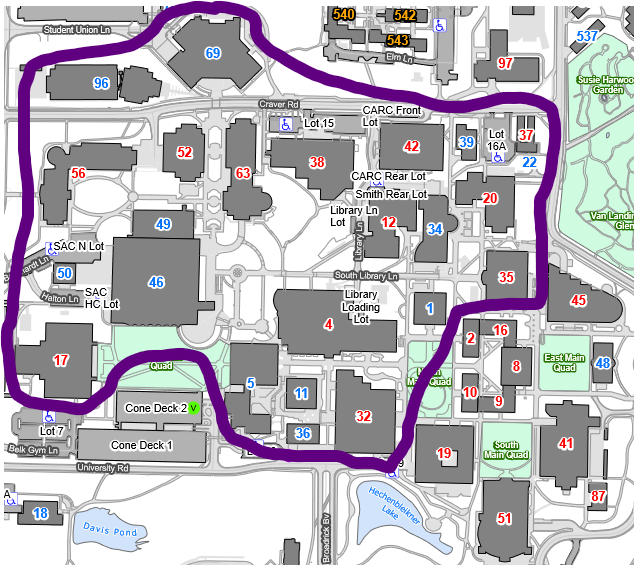


In [3]:
# Start Data processing
y_labels = []
# Create dictionary to sort and label the data
labels = {'Atkins', 'Smith', 'Belk', 'Colvard', 'Smith', 'Prospector', 'Burson', 'SAC', 'Cato', 'Woodward', 'CHHS', 'Student Union', 'UREC'}

In [4]:
# Loop through each folder
for folder in os.listdir():
  foldername = os.fsdecode(folder)
  for label in labels:
    if label in foldername:
      # Gather the length of folder and add the respective amount of labels needed to represent the image objects
      lst = os.listdir(foldername) # your directory path
      number_files = len(lst)
      y_labels.extend([label] * number_files)
     

In [5]:
images = []

# Loop through each image in all the folders
print("Loading images... Please wait... (Expect this to take around 5 mins)")

for folder in os.listdir():
  foldername = os.fsdecode(folder)
  for filename in os.listdir(foldername):
    # load and process the images
    filenamenew = foldername + '/' + filename 
    
    #print(filenamenew)
    img = cv2.imread(filenamenew)
    #IMPORTANT!!!! If you have less than 8GB of ram, change (256,256) to (64,64) when running
    img = cv2.resize(img, (64,64), cv2.INTER_LINEAR)

    # add image to the array
    images.append((img.astype(np.float)/255*2-1).transpose(2,0,1))

print(len(images), "images loaded!")
bundle = list(zip(images, y_labels))
    

Loading images... Please wait... (Expect this to take around 5 mins)
2720 images loaded!


The print statement below will display the number of sample images that make-up our dataset. Number of images: 2720 

In [6]:
print('Number of images: ', len(images))

Number of images:  2720


The array that is displayed below represents the classification types of the model. The classification represent the building name that is associated with the respective image. The building labels: ['Atkins' 'Belk' 'Burson' 'CHHS' 'Cato' 'Colvard' 'Prospector' 'SAC'
 'Smith' 'Student Union' 'UREC' 'Woodward']

In [7]:
print('Class labels:', np.unique(y_labels))

Class labels: ['Atkins' 'Belk' 'Burson' 'CHHS' 'Cato' 'Colvard' 'Prospector' 'SAC'
 'Smith' 'Student Union' 'UREC' 'Woodward']


## Training/Test Split Methodology:

While training our model, we will be using a training/test split of 80%(training) and 20%(test).

## Visualization:

Below shows various images in the dataset along with their repective labels.

Prospector


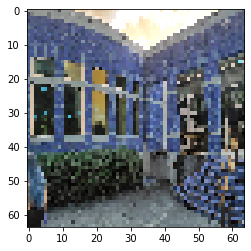

Prospector


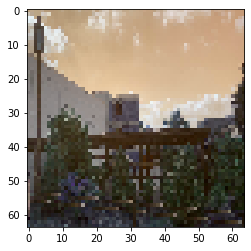

Colvard


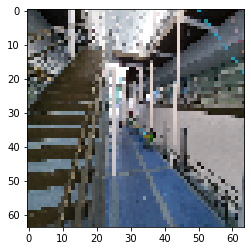

Student Union


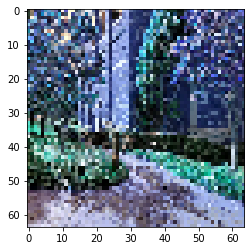

Student Union


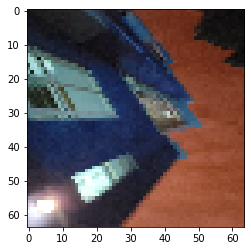

In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    img = img.transpose(1,2,0)
    npimg = np.array(img)
    
    plt.figure
    plt.imshow(npimg)
    plt.show()


for n in range(5):
    random.shuffle(bundle)
    img, label = bundle[0][0], bundle[0][1]
    print(label)
    imshow(img)

In [9]:
print(type(bundle))

<class 'list'>


In [9]:
import time
import glob

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split


In [10]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn import preprocessing

In [22]:
import torch.optim as optim
import time
  
def trainModel(net, trainloader, train_option, testloader=None):  
  loss_func = nn.CrossEntropyLoss()
  lr = train_option['lr']
  epoch = train_option['epoch']
  device = train_option['device'] if 'device' in train_option.keys() else 'cpu'
  log_iter = train_option['log_iter'] if 'log_iter' in train_option.keys() else 20
  eval_epoch = 1
  

  optimizer = optim.SGD(net.parameters(), lr=lr)

  start_time = time.time()
  if device == 'gpu':
    net = net.cuda()
    
  iters = 0
  running_loss = 0.0
  for ep in range(epoch):
    net.train()        
    for iter, (x, y) in enumerate(trainloader):
      iters += 1
      batch_x = Variable(x).float()
      batch_y = Variable(y).long()
      if device == 'gpu':
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

      outputs = net(batch_x)
      loss = loss_func(outputs, batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      
      time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
      if iter % log_iter == 0:
        print('Epoch:{:2d} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f} '.format(ep+1, iter, time_lapse, loss.item(), running_loss/iters))
   
    if testloader is not None and ep % eval_epoch == 0:
      evalModel(net, testloader)

In [31]:
import time

def evalModel(net, testloader): 
  acc = 0.0
  count = 0
  start_time = time.time()
  device = 'gpu' if next(net.parameters()).is_cuda else 'cpu'
  net.eval()
  
  for iter, (x, y) in enumerate(testloader):
    count += x.shape[0]
    batch_x = Variable(x).float()
    batch_y = Variable(y).long()
    if device == 'gpu':
      batch_x = batch_x.cuda()
      batch_y = batch_y.cuda()
    outputs = net(batch_x)
    _, predicted = torch.max(outputs.data, 1)
    acc += (predicted == batch_y).sum().item()

  print("Predicted Label Type: ", type(predicted), " Actual Label Type: ", type(batch_y))
  print("Count: ", count)
        
  time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))        
  print('Accuracy: {:5f} | Time: {}'.format(acc/count,time_lapse))

In [61]:
import torch.optim as optim


def train(net, trainloader, lr=0.0001, epochs=15, device='gpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr)

    if device == 'gpu':
        net = net.cuda()
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            batch_x = Variable(inputs).float()
            batch_y = Variable(labels).long()
            if device == 'gpu':
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            #print average loss and training loss every 30 mini-batches
            if i % 30 == 29:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 30))
                running_loss = 0.0
                
            running_loss = 0.0
            

    print('Finished Training')


In [14]:
class BuildingImageDataset(Dataset):
    def __init__(self, transform=None, y_labels=[], images=[]):
        self.data_labels = y_labels
        self.data_images = torch.Tensor(images)
        
    def __len__(self):
        return len(self.data_images)

    def __getitem__(self, idx):
        image = self.data_images[idx]
        label = self.data_labels[idx]
        return image, label

In [53]:
# shuffle the y_labels and images
temp = list(zip(y_labels, images))
random.shuffle(temp)
y_labels, images = zip(*temp)
# convert string labels to int tensors
le = preprocessing.LabelEncoder()
# print(y_labels)
pre_y_labels = le.fit_transform(y_labels)
# print(pre_y_labels)
build_data = BuildingImageDataset(y_labels=pre_y_labels[:2448], images=images[:2448])
test_data = BuildingImageDataset(y_labels=pre_y_labels[2448:], images=images[2448:])


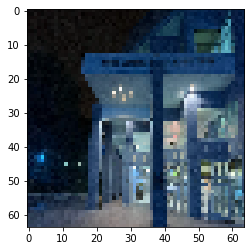

['SAC']


In [54]:
# Check data
first_data = build_data[1000]
feature, label = first_data
imshow(feature.numpy())
print(le.inverse_transform([label]))

In [55]:
#data loader
train_data_loader = DataLoader(dataset=build_data, batch_size=20, shuffle=True)
test_data_loader = DataLoader(dataset=test_data, batch_size=20, shuffle=True)

# print number of batches
print('Training Batches: ', str(len(train_data_loader)))
print('Testing Batches: ', str(len(test_data_loader)))


Training Batches:  123
Testing Batches:  14


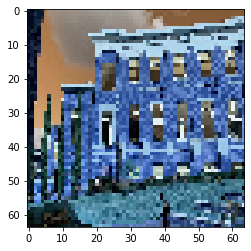

['Student Union']


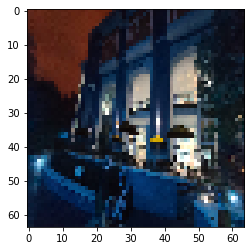

['Student Union']


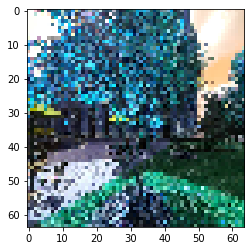

['Student Union']


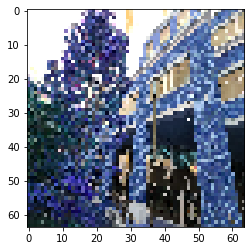

['Atkins']


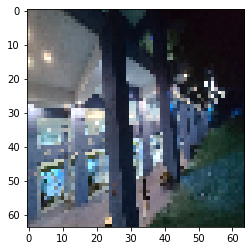

['SAC']


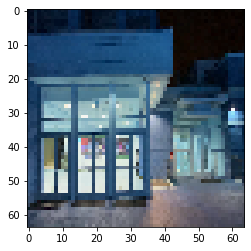

['SAC']


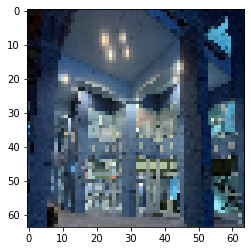

['SAC']


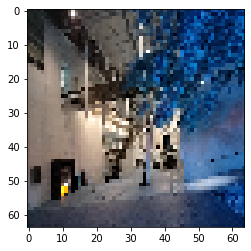

['Colvard']


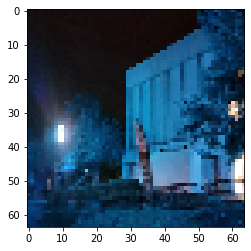

['Atkins']


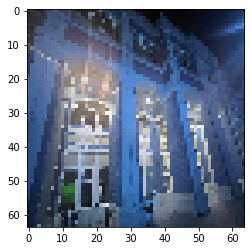

['CHHS']


KeyboardInterrupt: 

In [57]:
# test code
count = 1
for i, data in enumerate(train_data_loader):
    if count > 5:
        break
    count += 1
    inputs, labels = data
    for feature, lab in zip(inputs, labels):
        imshow(feature.numpy())
        print(le.inverse_transform([lab]))
    

In [58]:
# Create model
model = torchvision.models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 12)

In [59]:
train(model, train_data_loader)

[1,    30] loss: 0.082
[1,    60] loss: 0.080
[1,    90] loss: 0.077
[1,   120] loss: 0.075
[2,    30] loss: 0.077
[2,    60] loss: 0.074
[2,    90] loss: 0.070
[2,   120] loss: 0.067
[3,    30] loss: 0.069
[3,    60] loss: 0.066
[3,    90] loss: 0.074
[3,   120] loss: 0.069
[4,    30] loss: 0.067
[4,    60] loss: 0.075
[4,    90] loss: 0.066
[4,   120] loss: 0.060
[5,    30] loss: 0.067
[5,    60] loss: 0.072
[5,    90] loss: 0.063
[5,   120] loss: 0.062
[6,    30] loss: 0.069
[6,    60] loss: 0.060
[6,    90] loss: 0.068
[6,   120] loss: 0.067
[7,    30] loss: 0.061
[7,    60] loss: 0.059
[7,    90] loss: 0.061
[7,   120] loss: 0.063
[8,    30] loss: 0.064
[8,    60] loss: 0.064
[8,    90] loss: 0.071
[8,   120] loss: 0.054
[9,    30] loss: 0.067
[9,    60] loss: 0.061
[9,    90] loss: 0.061
[9,   120] loss: 0.076
[10,    30] loss: 0.052
[10,    60] loss: 0.051
[10,    90] loss: 0.046
[10,   120] loss: 0.060
[11,    30] loss: 0.056
[11,    60] loss: 0.061
[11,    90] loss: 0.068
[11,

In [60]:
evalModel(model, test_data_loader)

Predicted Label Type:  <class 'torch.Tensor'>  Actual Label Type:  <class 'torch.Tensor'>
Count:  272
Accuracy: 0.444853 | Time: 00:00:00


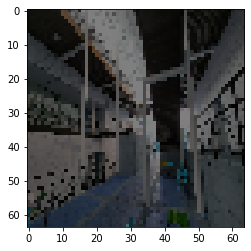

Prediction:  ['Colvard']


In [40]:
#Input an image and get a prediction of the class
def img_load(file_path):
    
    img = cv2.imread(file_path)
    img = cv2.resize(img, (64,64), cv2.INTER_LINEAR)
    img = np.transpose(img, [2, 0, 1])
    return img.astype(np.float)/(255*2-1)

# show some images
def displayimg(img):
     # unnormalize
    if len(img.shape) > 2:
        img = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(img, 'gray')
    plt.show()


def predict(net, img, device='gpu'):
    net.eval()
    if device == 'gpu':
        net = net.cuda()
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = Variable(img).float()
    if device == 'gpu':
        img = img.cuda()
    outputs = net(img)
    return outputs.max(1)[1].item()

def convert_label(label):
    return le.inverse_transform([label])

img = img_load('./32 - Colvard/Colvard (160).jpg')

prediction = (predict(model, img))
displayimg(img)
print("Prediction: ", convert_label(prediction))


In [54]:
evalModel(net=model, testloader=test_data_loader)

Accuracy: 0.004839 | Time: 00:00:00


In [65]:
torch.cuda.empty_cache()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [83]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 